In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as SklearnLR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Đọc dữ liệu và tiền xử lý cơ bản

In [153]:
# Đọc dữ liệu
df = pd.read_csv("forestfires.csv")
print("Top 5 rows of original data:")
df.head(5)

Top 5 rows of original data:


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [154]:
# Kiểm tra các cột về missing/null
for col in df.columns:
    print(f"{col}: Total NaN={df[col].isna().sum()}, Total null={df[col].isnull().sum()}, dtype={df[col].dtype}")

X: Total NaN=0, Total null=0, dtype=int64
Y: Total NaN=0, Total null=0, dtype=int64
month: Total NaN=0, Total null=0, dtype=object
day: Total NaN=0, Total null=0, dtype=object
FFMC: Total NaN=0, Total null=0, dtype=float64
DMC: Total NaN=0, Total null=0, dtype=float64
DC: Total NaN=0, Total null=0, dtype=float64
ISI: Total NaN=0, Total null=0, dtype=float64
temp: Total NaN=0, Total null=0, dtype=float64
RH: Total NaN=0, Total null=0, dtype=int64
wind: Total NaN=0, Total null=0, dtype=float64
rain: Total NaN=0, Total null=0, dtype=float64
area: Total NaN=0, Total null=0, dtype=float64


In [155]:
# Chuyển đổi cột 'month' và 'day' sang số
def convert_month(month: str):
    month_dict = {
        "jan": 1, "feb": 2, "mar": 3, "apr": 4,
        "may": 5, "jun": 6, "jul": 7, "aug": 8,
        "sep": 9, "oct": 10, "nov": 11, "dec": 12
    }
    return month_dict[month]

In [156]:
def convert_day(day: str):
    day_dict = {
        "sun": 0, "mon": 1, "tue": 2, "wed": 3, "thu": 4, "fri": 5, "sat": 6
    }
    return day_dict[day]

In [157]:
df["month"] = df["month"].apply(convert_month)
df["day"] = df["day"].apply(convert_day)

In [158]:
# Lưu dữ liệu gốc để dùng cho Assignment 1 & 4
df_original = df.copy()

### Assignment 1 (3 scores):

- Use the Numpy library only to construct the Linear Regression model.
- Train and Evaluate that Linear Regression model on the [Forest Fires](https://archive.ics.uci.edu/static/public/162/forest+fires.zip) dataset.

In [159]:
# Hàm thêm cột bias
#def add_bias(X):
    #bias = np.ones((X.shape[0], 1))
    #return np.hstack((bias, X))

In [160]:
# Xác định biến mục tiêu và features
target = df_original["area"].values
features = df_original.drop(columns=["area"])
#X_orig = add_bias(features.to_numpy())
#X_orig = features.to_numpy()

Buildidng Linear Regression model

In [161]:
class LinearRegression:
    def rmse(self, y: np.ndarray, y_hat: np.ndarray):
        delta = y - y_hat
        return np.square(delta).mean()**0.5
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        cov = np.matmul(X.T, X)
        inv_cov = np.linalg.inv(cov)
        self.theta_: np.ndarray = inv_cov @ (X.T @ y)
        
    def predict(self, X: np.ndarray):
        y_pred = np.matmul(self.theta_.T, X.T)
        return y_pred

In [162]:
lr = LinearRegression()

Defining the input and output vectors

In [163]:
X_y = df.to_numpy()
X_y.shape

(517, 13)

In [164]:
N = df.shape[0]
X_y_train, X_y_test = np.split(X_y, indices_or_sections = [int(0.8*N)])

In [165]:
X_train, X_test = X_y_train[:, :-1], X_y_test[:, :-1]
X_train.shape, X_test.shape

((413, 12), (104, 12))

In [166]:
y_train, y_test = X_y_train[:, -1], X_y_test[:, -1]
y_train.shape, y_test.shape

((413,), (104,))

Fitting the model and visualizing the results

In [167]:
lr.fit(X_train, y_train)

In [168]:
lr.theta_

array([ 0.93387474, -0.3472708 ,  2.97274599,  1.69617548, -0.08518378,
        0.11686352, -0.02830015, -0.88678297,  0.43970684, -0.18297875,
        0.04626583, -6.54744483])

In [169]:
lr.theta_.shape

(12,)

In [170]:
y_pred = lr.predict(X_test)

In [171]:
rmse_orig = lr.rmse(y_pred, y_test)
print("\nAssignment 1 (Original Data) - Linear Regression RMSE: {:.5f}".format(rmse_orig))


Assignment 1 (Original Data) - Linear Regression RMSE: 79.42477


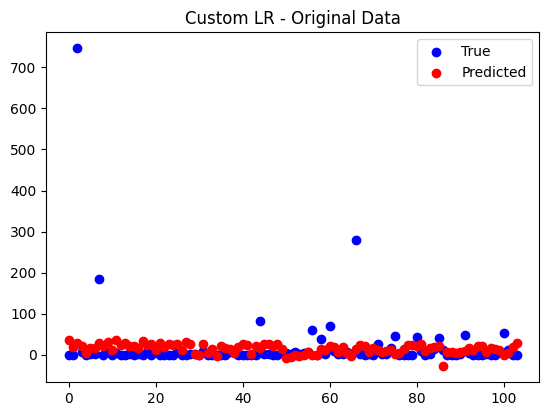

In [172]:
plt.figure(figsize=(14, 10))

# Custom model trên dữ liệu gốc
plt.subplot(2, 2, 1)
plt.scatter(range(len(y_test)), y_test, c="b", label="True")
plt.scatter(range(len(y_test)), y_pred, c="r", label="Predicted")
plt.title("Custom LR - Original Data")
plt.legend()

### Assignment 2 (3 scores):

- Standardize the data so that their mean is $0$ and their variance is $1$.
- Compare the results of Linear Regression model when being trained on the original and standardized data.

In [173]:
# Chuẩn hóa các cột số thực (FFMC, DMC, DC, ISI, temp, RH, wind, rain)
real_valued_cols = ["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"]
df_std = df_original.copy()
df_std[real_valued_cols] = (df_std[real_valued_cols] - df_std[real_valued_cols].mean()) / df_std[real_valued_cols].std()

In [174]:
# Lấy dữ liệu chuẩn hóa
target_std = df_std["area"].values
features_std = df_std.drop(columns=["area"])
#X_std = add_bias(features_std.to_numpy())
X_std = features_std.to_numpy()

In [175]:
# Chia dữ liệu
N_std = X_std.shape[0]
X_train_std, X_test_std = np.split(X_std, [int(0.8 * N_std)])
y_train_std, y_test_std = np.split(target_std, [int(0.8 * N_std)])

In [176]:
# Huấn luyện và đánh giá mô hình custom trên dữ liệu chuẩn hóa
model_std = LinearRegression()
model_std.fit(X_train_std, y_train_std)
y_pred_std = model_std.predict(X_test_std)
rmse_std = model_std.rmse(y_test_std, y_pred_std)
print("Assignment 2 (Standardized Data) - Custom Linear Regression RMSE: {:.4f}".format(rmse_std))

Assignment 2 (Standardized Data) - Custom Linear Regression RMSE: 79.5150


In [177]:
def plot_comparison(y_test1, y_pred1, title1, y_test2, y_pred2, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Tạo 1 hàng, 2 cột
    # Biểu đồ thứ nhất
    ax1.scatter(range(len(y_test1)), y_test1, color='blue', label='True Values')
    ax1.scatter(range(len(y_test1)), y_pred1, color='red', label='Predicted Values')
    ax1.set_title(title1)
    ax1.legend()
    # Biểu đồ thứ hai
    ax2.scatter(range(len(y_test2)), y_test2, color='blue', label='True Values')
    ax2.scatter(range(len(y_test2)), y_pred2, color='red', label='Predicted Values')
    ax2.set_title(title2)
    ax2.legend()
    plt.show()

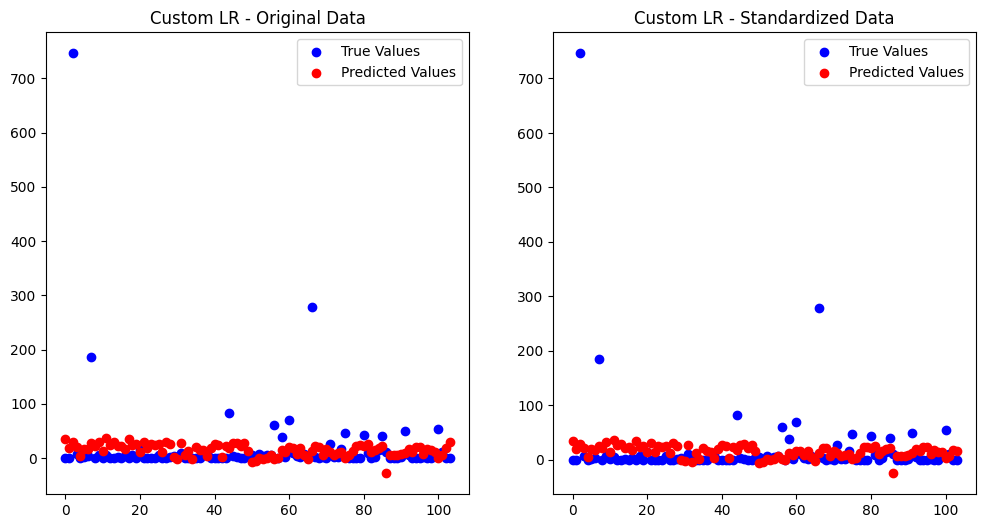

In [178]:
plot_comparison(y_test, y_pred, 'Custom LR - Original Data',
                y_test_std, y_pred_std, 'Custom LR - Standardized Data')

Assignment 1 (Original Data) - Linear Regression RMSE: 79.42477
Assignment 2 (Standardized Data) - Linear Regression RMSE: 79.5150
-> Không có sự khác biệt đáng kể, chênh lệch 0.1

### Assignment 3 (2 scores):

- Perform feature engineering to remove columns that are linearly dependent (colinear) with other columns in the dataset.
- Evaluate the Linear Regression model when beeing trained on the original data and preprocessed data.

In [179]:
import seaborn as sns

Visualizing data

In [180]:
cov = np.zeros((len(df_std.columns[:-1]), len(df_std.columns[:-1])))
for i, col_name_i in enumerate(df_std.columns[:-1]):
    for j, col_name_j in enumerate(df_std.columns[:-1]):
        cov[i,j] =  np.corrcoef(df_std[col_name_i].to_numpy(), df_std[col_name_j].to_numpy())[0,1]

<Axes: >

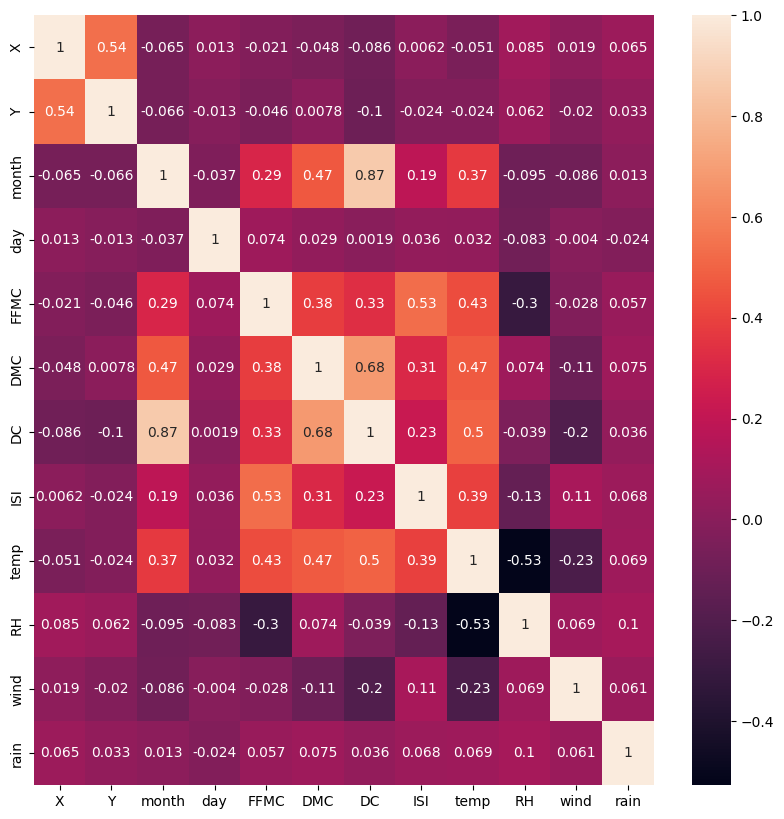

In [181]:
plt.figure(figsize=(10,10))
sns.heatmap(cov, xticklabels=df_std.columns[:-1], yticklabels=df_std.columns[:-1], annot=cov)

In [182]:
target = df["area"].values
# Chọn các cột số để làm features là số thực (trừ biến mục tiêu 'area')
numeric_cols = df_std.select_dtypes(include=[np.number]).columns.tolist()
if "area" in numeric_cols:
    numeric_cols.remove("area")
features_std_numeric = df_std[numeric_cols].copy()

In [183]:
# Hàm loại bỏ các feature đồng biến dựa trên ma trận tương quan
def remove_collinear_features(data, threshold=0.85):
    corr_matrix = data.corr().abs()
    # Chỉ lấy phần tam giác trên
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    data_reduced = data.drop(columns=to_drop)
    return data_reduced, to_drop

In [184]:
features_reduced, dropped_features = remove_collinear_features(features_std_numeric, threshold=0.85)
print("Assignment 3 - Các feature bị loại bỏ do colinearity:", dropped_features)

Assignment 3 - Các feature bị loại bỏ do colinearity: ['DC']


In [185]:
# Tạo dữ liệu với features sau khi loại bỏ colinear
X_reduced = features_reduced.to_numpy()
data_reduced = np.hstack((X_reduced, target.reshape(-1, 1)))
# Chia dữ liệu theo thứ tự 80/20
N_reduced = X_reduced.shape[0]
X_train_reduced, X_test_reduced = np.split(X_reduced, [int(0.8 * N_reduced)])
y_train_reduced, y_test_reduced = np.split(target, [int(0.8 * N_reduced)])

In [186]:
# Huấn luyện và đánh giá mô hình custom trên dữ liệu sau tiền xử lý
custom_model_reduced = LinearRegression()
custom_model_reduced.fit(X_train_reduced, y_train_reduced)
y_pred_reduced = custom_model_reduced.predict(X_test_reduced)
rmse_reduced = custom_model_reduced.rmse(y_test_reduced, y_pred_reduced)
print("Assignment 3 (Preprocessed Reduced Features) - Custom Linear Regression RMSE: {:.4f}".format(rmse_reduced))

Assignment 3 (Preprocessed Reduced Features) - Custom Linear Regression RMSE: 79.5409


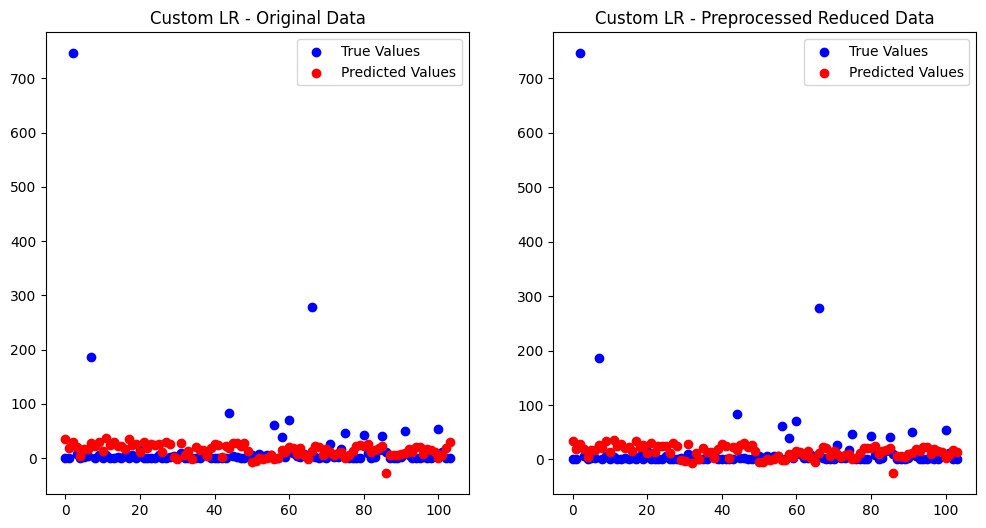

In [187]:
plot_comparison(y_test, y_pred, 'Custom LR - Original Data',
                y_test_reduced, y_pred_reduced, 'Custom LR - Preprocessed Reduced Data')

Assignment 1 (Original Data) - Linear Regression RMSE: 79.42477
Assignment 3 (Preprocessed Reduced Features) - Custom Linear Regression RMSE: 79.5409
-> Không có sự khác biệt đáng kể, chênh lệch 0.1

### Assignment 4 (2 scores):

- Implement the Linear Regression model using Machine Learning libraries (Scikit Learn or SKorch).
- Compare the results of Linear Regression model constructed manually and from Machine Learning libraries.

In [ ]:
X_sk = features.to_numpy()
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(X_sk, target, test_size=0.2, random_state=42, shuffle= False)

sk_model = SklearnLR()
sk_model.fit(X_train_sk, y_train_sk)
y_pred_sk = sk_model.predict(X_test_sk)

#Tính RMSE
rmse_sk = np.sqrt(mean_squared_error(y_test_sk, y_pred_sk))
print("Assignment 4 - Sklearn Linear Regression RMSE (Original Data): {:.4f}".format(rmse_sk))

Assignment 4 - Sklearn Linear Regression RMSE (Original Data): 79.4242


In [215]:
X_sk_std = features_std.to_numpy()
X_train_sk_std, X_test_sk_std, y_train_sk_std, y_test_sk_std = train_test_split(X_sk_std, target, test_size=0.2, random_state=42, shuffle= False)

sk_model = SklearnLR()
sk_model.fit(X_train_sk_std, y_train_sk_std)
y_pred_sk_std = sk_model.predict(X_test_sk_std)

#Tính RMSE
rmse_sk_std = np.sqrt(mean_squared_error(y_test_sk_std, y_pred_sk_std))
print("Assignment 4 - Sklearn Linear Regression RMSE (Standardized Data): {:.4f}".format(rmse_sk_std))

Assignment 4 - Sklearn Linear Regression RMSE (Standardized Data): 79.4242


In [210]:
X_sk_re = features_reduced.to_numpy()
X_train_sk_re, X_test_sk_re, y_train_sk_re, y_test_sk_re = train_test_split(X_sk_re, target, test_size=0.2, random_state=42, shuffle= False)

sk_model = SklearnLR()
sk_model.fit(X_train_sk_re, y_train_sk_re)
y_pred_sk_re = sk_model.predict(X_test_sk_re)
#Tính RMSE
rmse_sk_re = np.sqrt(mean_squared_error(y_test_sk_re, y_pred_sk_re))
print("Assignment 4 - Sklearn Linear Regression RMSE (Preprocessed Reduced Data): {:.4f}".format(rmse_sk_re))

Assignment 4 - Sklearn Linear Regression RMSE (Preprocessed Reduced Data): 79.5332


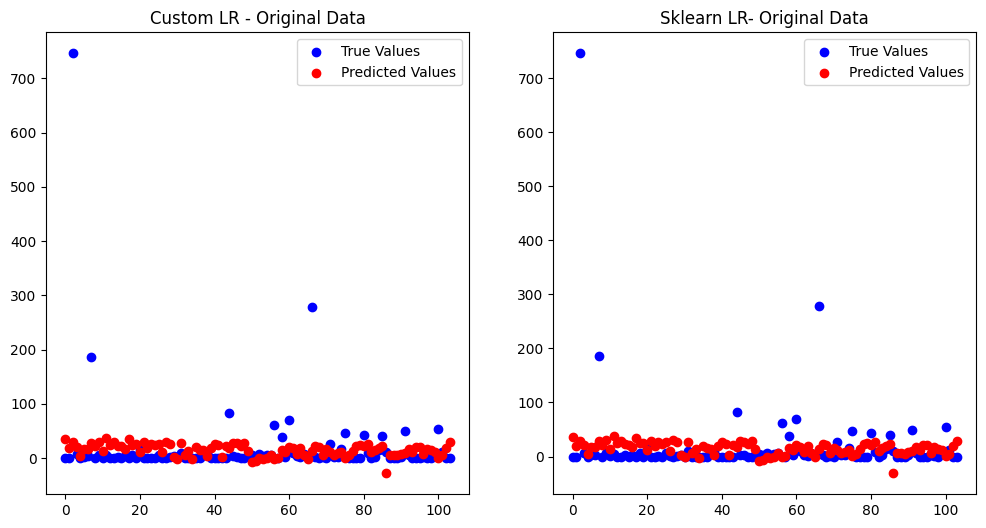

In [211]:
plot_comparison(y_test, y_pred, 'Custom LR - Original Data',
                y_test_sk, y_pred_sk, 'Sklearn LR- Original Data')

Assignment 1 (Original Data) - Linear Regression RMSE: 79.42477
Assignment 4 - Sklearn Linear Regression RMSE (Original Data): 79.4242
-> chênh lệch ko đáng kể

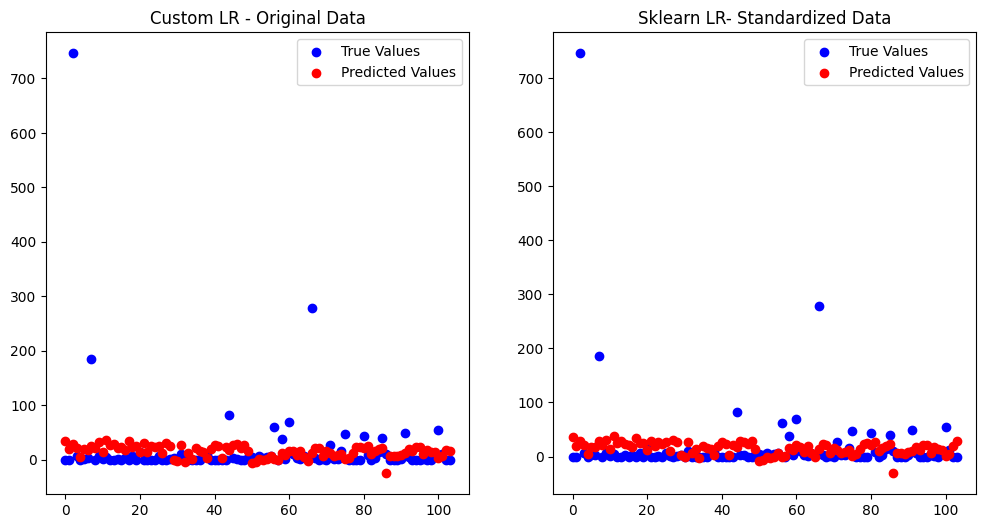

In [216]:
plot_comparison(y_test_std, y_pred_std, 'Custom LR - Original Data',
                y_test_sk_std, y_pred_sk_std, 'Sklearn LR- Standardized Data')

Assignment 2 (Standardized Data) - Custom Linear Regression RMSE: 79.5150
Assignment 4 - Sklearn Linear Regression RMSE (Standardized Data): 79.4242
-> chênh lệch ko đáng kể

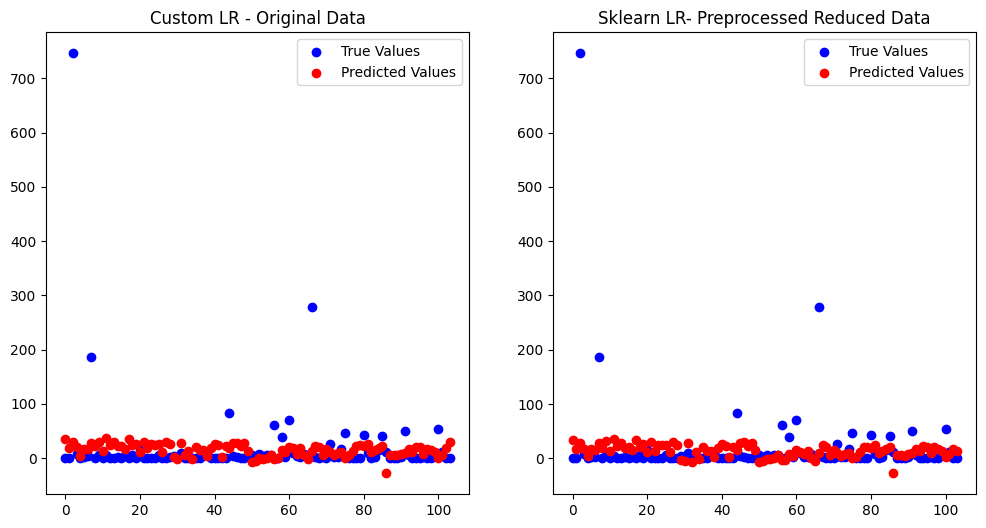

In [213]:
plot_comparison(y_test, y_pred, 'Custom LR - Original Data',
                y_test_sk_re, y_pred_sk_re, 'Sklearn LR- Preprocessed Reduced Data')

Assignment 3 (Preprocessed Reduced Features) - Custom Linear Regression RMSE: 79.5409
Assignment 4 - Sklearn Linear Regression RMSE (Preprocessed Reduced Data): 79.5332
-> chênh lệch ko đáng kể